In [1]:
#!python -m pip install torch
import torch
import torch.nn as nn 
import torch.nn.functional as f
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
#!python -m pip install tensorflow
import auto_encoder
import math
import bisect
import pickle
import copy
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def seed(num_samples):
    pts = []
    i = 0
    it1 = int(math.sqrt(num_samples)/10)
    it2 = int((num_samples/10) - math.sqrt(num_samples))
    for j in range (10):
        for k in range(10):
            pts.append(i)
            i+=it1
        i+=it2
    return pts

In [3]:
def seq_to_magnetization(arr_seq, num_qubits):
    
    mag_vec = []
    for elem in arr_seq:
        magnetization = 0
        for char in elem:
            temp = (int(char)*-2)+1
            magnetization += temp 
        mag_vec.append(magnetization)
    mag_vec = np.array(mag_vec)
    mag_vec = mag_vec / (num_qubits)
    return mag_vec   

def seq_gen(num_q):
    if num_q == 2:
        return ['00','01', '10','11']
    else:
        temp = []
        
        smaller_vals = seq_gen(num_q-1)
        for i in ['0','1']:
            for each in smaller_vals:
                temp.append(i+each)
        return temp 

In [4]:
def error_points(predicted, truth, num):
    diffs = abs((predicted+1) - (truth+1))/(truth+1)
    array = np.mean(diffs, axis=1)
    points = (-np.asarray(array)).argsort()[:num]
    return points

In [5]:
def mean_error(predicted, truth):
    diffs = abs((predicted+1) - (truth+1))/(truth+1)
    return np.mean(np.mean(diffs, axis=1)) 

In [6]:
def error_data(mag, mag_t):
    diffs = abs(((mag+1) - (mag_t+1))/(mag_t+1))
    return np.mean(diffs, axis=1)

In [7]:
def print_points(data1, qubits, error_points):    
    data = np.load(data1)
    Bx = data['fields'].T[qubits]
    Bz = data['fields'].T[2*qubits]
    points = []
    for i in error_points:
        points.append((Bx[i],Bz[i]))
    print(points)

In [8]:
def expand_pool(old_pool, error_points, max_pool_size, add_pts):
    added = 0
    wait = []
    for i in error_points:
        if(i not in old_pool):
            bisect.insort(old_pool,i)
            added = added+1      
        else:
            wait.append(i)
            
    while(added<add_pts and len(wait) > 0):
        i = wait[0]
        num = int(i)
        Bz_low_num = num-1
        Bz_high_num= num+1
        Bz_low_flag=True
        Bz_high_flag=True

        Bx_low_num = int(num-math.sqrt(max_pool_size))
        Bx_high_num= int(num+math.sqrt(max_pool_size))
        Bx_low_flag=True
        Bx_high_flag=True

        while(Bz_low_flag or Bz_high_flag or Bx_low_flag or Bx_high_flag):
            if(Bz_low_flag):
                if(Bz_low_num<=0 or Bz_low_num % math.sqrt(max_pool_size)==math.sqrt(max_pool_size)-1):
                    Bz_low_flag=False
                elif(Bz_low_num not in old_pool):
                    bisect.insort(old_pool,Bz_low_num)
                    Bz_low_flag=False
                else:
                    Bz_low_num-=1
            if(Bz_high_flag):
                if(Bz_high_num>=max_pool_size or Bz_high_num % math.sqrt(max_pool_size)==0):
                    Bz_high_flag=False
                elif(Bz_high_num not in old_pool):
                    bisect.insort(old_pool, Bz_high_num)
                    Bz_high_flag=False
                else:
                    Bz_high_num+=1
            if(Bx_low_flag):
                if(Bx_low_num<=0):
                    Bx_low_flag=False
                elif(Bx_low_num not in old_pool):
                    bisect.insort(old_pool, Bx_low_num)
                    Bx_low_flag=False
                else:
                    Bx_low_num-=int(math.sqrt(max_pool_size))
            if(Bx_high_flag):
                if(Bx_high_num>=max_pool_size or Bx_high_num % math.sqrt(max_pool_size)==0):
                    Bx_high_flag=False
                elif(Bx_high_num not in old_pool):
                    bisect.insort(old_pool, Bx_high_num)
                    Bx_high_flag=False
                else:
                    Bx_high_num+=int(math.sqrt(max_pool_size))
                    
            added=added+4
                    
    return old_pool

In [9]:
get_dataset = auto_encoder.get_dataset
data_2 = '2_qubit_crit_data_1.npz'
data_4 = '4_qubit_crit_data_1.npz'
data_6 = '6_qubit_crit_data_1.npz'
data_7 = '7_qubit_crit_data_1.npz'
data_8 = '8_qubit_crit_data.npz'
# data_9 = '9_qubit_crit_data.npz'

v_data_2 = '2_qubit_val_data.npz'
v_data_4 = '4_qubit_val_data.npz'
v_data_7 = '7_qubit_val_data.npz'

#     val_data_9 = get_dataset(data_9, 9, pool_size)

validation_n_sizes = [6,8]
mps_size = 5
device = torch.device("cpu")
model = auto_encoder.MPS_autoencoder(mps_size = mps_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_sizes = [2,4,7]
val_sizes = [6,8,2,4,7]

pool_size = 10000
val_size = 1089

pts = seed(pool_size)

error_p = []

magnetization_6 = []
wave_func_6 = []

val_data_2 = get_dataset(v_data_2, 2, val_size)
val_data_4 = get_dataset(v_data_4, 4, val_size)
val_data_7 = get_dataset(v_data_7, 7, val_size)
val_data_6 = get_dataset(data_6, 6, pool_size)
val_data_8 = get_dataset(data_8, 8, 2500)

val_datasets = [val_data_6, val_data_8, val_data_2, val_data_4, val_data_7] # val_data_9

val_loaders = [DataLoader(x, batch_size = 10, num_workers=5) for x in val_datasets]

val_6 = next(iter(val_loaders[0]))
val_8 = next(iter(val_loaders[1]))
#val_9 = next(iter(val_loaders[2]))
val_2 = next(iter(val_loaders[2]))
val_4 = next(iter(val_loaders[3]))
val_7 = next(iter(val_loaders[4]))

stop = .05
runs = 0
prev_err = 999
increase_points = 5

In [10]:
while(True):
    runs = runs+1
    
    training_data_2 = auto_encoder.get_dataset_active(data_2,2,pool_size, pts)
    training_data_4 = auto_encoder.get_dataset_active(data_4,4,pool_size, pts)
    training_data_7 = auto_encoder.get_dataset_active(data_7,7,pool_size, pts) 


    datasets = [training_data_2,
                training_data_4,
                training_data_7]

    training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=5) for x in datasets]

    print("Training Validation ", runs)
    
    model, tot_err, val_err, t_errs, val_errs = auto_encoder.mps_fit(device, model, optimizer, mps_size, training_loaders, train_sizes, val_loaders, val_sizes) 
      
    print("VALIDATION LOSS ITERATION: ", runs)
    val_data = [(val_6,6),(val_8,8),(val_2,2),(val_4,4),(val_7,7)]
    #val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
    loss_func = nn.MSELoss()
    count=0
    for data, size in val_data:
        with torch.no_grad():
            fields, wf = data
            gs = model(fields, size)
            loss = loss_func(gs,wf)
            current = loss.item() * (2**size)
            print(size,"\t" ,current)

    print("__________________________________________________")
    print()

    f = open("test_data_1.p", 'wb')
    pickle.dump(val_data, f)

    for N, train_loader in enumerate(training_loaders):            
        temp = 0
        sys_size = train_sizes[N]
        for i, (fields,wf) in enumerate(train_loader):
            fields = fields.to(device)
            gs = model(fields, sys_size)            
            loss = loss_func(gs, wf.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            temp += loss.item()
        temp = temp / (len(train_loader)) 

    data_sizes = [2,4,6,7,8]#,9]

    mag_dat = [training_data_2,training_data_4,val_data_6,training_data_7, val_data_8]#, val_data_9]
    mag_loaders = [DataLoader(x, batch_size = len(val_data_6), num_workers=5) for x in mag_dat]

    model.eval()
    with torch.no_grad():
        n_systems = {}
        for j,loader in enumerate((mag_loaders)):
            sys_size = data_sizes[j]
            wave_functions = []
            true_wave = []
            for i, (fields,wf) in enumerate(loader):
                fields = fields
                gs = model(fields, sys_size)

                wave_functions.append(gs)
                true_wave.append(wf)

            n_systems[sys_size] = (wave_functions,true_wave)


    #     data_y_2 = n_systems[2][0][0].numpy()
    #     data_y_4 = n_systems[4][0][0].numpy()
    #     data_y_7 = n_systems[7][0][0].numpy()
    data_y_6 = n_systems[6][0][0].numpy()
    #     data_y_8 = n_systems[8][0][0].numpy()
    #     data_y_9 = n_systems[9][0][0].numpy()


    #     print(data_y_2.shape)
    #     data_y_2_t = n_systems[2][1][0].numpy()
    #     data_y_4_t = n_systems[4][1][0].numpy()
    #     data_y_7_t = n_systems[7][1][0].numpy()
    data_y_6_t = n_systems[6][1][0].numpy()
    #     data_y_8_t = n_systems[8][1][0].numpy()
    #     data_y_9_t = n_systems[9][1][0].numpy()

    #     vec = seq_to_magnetization(seq_gen(2),2)
    #     vec_2 = (vec.view()).reshape((4,1))
    #     mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
    #     mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))

    #     vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
    #     mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
    #     mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))

    vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
    mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
    mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))

    magnetization_6.append(mag_6)

    #     vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
    #     mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
    #     mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))

    #     vec_8 = seq_to_magnetization(seq_gen(8),8).reshape((256,1))
    #     mag_8 = np.squeeze((np.power(data_y_8,2) @ vec_8))
    #     mag_8_t = np.squeeze((np.power(data_y_8_t,2) @ vec_8))

    #     vec_9 = seq_to_magnetization(seq_gen(9),9).reshape((512,1))
    #     mag_9 = np.squeeze((np.power(data_y_9,2) @ vec_9))
    #     mag_9_t = np.squeeze((np.power(data_y_9_t,2) @ vec_9))

    error_pts = error_points(data_y_6, data_y_6_t, increase_points)
    print("ERROR POINTS:")
    print_points(data_6, 6, error_pts)

    error_p.append(error_data(data_y_6,data_y_6_t))

    new_err = mean_error(data_y_6,data_y_6_t)
    
    if((prev_err - new_err)/prev_err > stop):
        pts = expand_pool(pts, error_pts, pool_size, increase_points)
        print("NEW SET: ")
        print(pts)
        print()
        print("_________________________________")
        prev_err = new_err
        
    else:
        break


Training Validation  1
Epoch 2 : 	 Training_Error: 2.23619 	 Val Error: 0.98849
********************************************************************************
2_qubit_loss: 0.08613 	 	 |4_qubit_loss: 0.25639 	 	 |7_qubit_loss: 1.89366 	 	 |
********************************************************************************
6_qubit_loss: 0.11498 	 	 |8_qubit_loss: 0.19446 	 	 |2_qubit_loss: 0.05261 	 	 |4_qubit_loss: 0.06631 	 	 |7_qubit_loss: 0.56013 	 	 |



Epoch 4 : 	 Training_Error: 0.47945 	 Val Error: 0.41684
********************************************************************************
2_qubit_loss: 0.06274 	 	 |4_qubit_loss: 0.09954 	 	 |7_qubit_loss: 0.31717 	 	 |
********************************************************************************
6_qubit_loss: 0.08247 	 	 |8_qubit_loss: 0.12101 	 	 |2_qubit_loss: 0.04384 	 	 |4_qubit_loss: 0.05333 	 	 |7_qubit_loss: 0.11620 	 	 |



Epoch 6 : 	 Training_Error: 0.41416 	 Val Error: 0.31140
****************************************

ERROR POINTS:
[(1.1111111111111112, 0.01), (1.1313131313131315, 0.01), (1.090909090909091, 0.01), (1.1515151515151516, 0.01), (1.0707070707070707, 0.01)]


In [11]:
print((prev_err - new_err)/prev_err)

-0.2701415


In [12]:
from tempfile import TemporaryFile

with open('magnetization_6_3.npy', 'wb') as f:
    np.save(f, magnetization_6)

with open('pts_3.npy', 'wb') as f:
    np.save(f, pts)   
    
with open('error_p_3.npy', 'wb') as f:
    np.save(f,error_p)


In [13]:
print(new_err)
torch.save(model.state_dict(), "Active_23.pt")

0.008224657


In [14]:
# with open('magnetization_6.npy', 'rb') as f:
#     magnetization_6 = np.load(f)

# with open('pts.npy', 'rb') as f:
#     pts = np.load(f)    
    
# with open('error_p.npy', 'rb') as f:
#     error_p = np.load(f)
    
# model = auto_encoder.MPS_autoencoder(mps_size)
# model.load_state_dict(torch.load("Mid_Actice_Learning_Model.pt", map_location=device)) 

# for learning_set in range (3):

#     training_data_2 = auto_encoder.get_dataset_active(data_2,2,pool_size, pts)
#     training_data_4 = auto_encoder.get_dataset_active(data_4,4,pool_size, pts)
#     training_data_7 = auto_encoder.get_dataset_active(data_7,7,pool_size, pts) 
# #     training_data_2 = auto_encoder.get_dataset(data_2,2,1)
# #     training_data_4 = auto_encoder.get_dataset(data_4,4,1)
# #     training_data_7 = auto_encoder.get_dataset(data_7,7,1) 
# #     val_data_2 = auto_encoder.get_dataset(data_2,2,1)
# #     val_data_4 = auto_encoder.get_dataset(data_4,4,1)
# #     val_data_7 = auto_encoder.get_dataset(data_7,7,1) 
    

#     split1 = int(len(pts)*0.9)
#     split2 = int(len(pts)/10)
#     split1 += len(pts)-(split1+split2)
    
#     training_data_2, val_data_2 = random_split(training_data_2, [split1,split2])
#     training_data_4, val_data_4 = random_split(training_data_4, [split1,split2])
#     training_data_7, val_data_7 = random_split(training_data_7, [split1,split2])

#     datasets = [training_data_2,
#                 training_data_4,
#                 training_data_7]

#     training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=20) for x in datasets]

#     val_data_6 = get_dataset(data_6, 6, pool_size)
#     val_data_8 = get_dataset(data_8, 8, pool_size)
# #     val_data_9 = get_dataset(data_9, 9, pool_size)

#     val_datasets = [val_data_6, val_data_8, val_data_2, val_data_4, val_data_7] # val_data_9

#     val_loaders = [DataLoader(x, batch_size = 10, num_workers=20) for x in val_datasets]

# #     warmup_2 = next(iter(training_loaders[0]))
# #     warmup_4 = next(iter(training_loaders[1]))
# #     warmup_7 = next(iter(training_loaders[2]))

# #     model = auto_encoder.MPS_autoencoder(mps_size = mps_size)
# #     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# #     loss_func = nn.MSELoss(reduction='sum')

# #     warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]

# #     print("WARMUP TRAINING ITERATION: ", learning_set)
# #     for j in range(10):
# #         for i in range(3):
# #             for epoch in range(10):
# #                 fields,wf = warmup_data[i][0]
# #                 gs = model(fields, warmup_data[i][1])            
# #                 loss = loss_func(gs, wf)
# #                 if (epoch % 10 == 0):
# #                     current_loss = loss.item() *(2**warmup_data[i][1])
# #                     print(warmup_data[i][1],"\t", current_loss)
# #                 optimizer.zero_grad()
# #                 loss.backward()
# #                 optimizer.step()
# #     print("__________________________________________________")
# #     print()

#     print("Training Validation ", learning_set)
#     val_6 = next(iter(val_loaders[0]))
#     val_8 = next(iter(val_loaders[1]))
#     #val_9 = next(iter(val_loaders[2]))
#     val_2 = next(iter(val_loaders[2]))
#     val_4 = next(iter(val_loaders[3]))
#     val_7 = next(iter(val_loaders[4]))
    
#     model, tot_err, val_err, t_errs, val_errs = auto_encoder.mps_fit(device, model, optimizer, mps_size, training_loaders, train_sizes, val_loaders, val_sizes) 
      
#     print("VALIDATION LOSS ITERATION: ", learning_set)
#     val_data = [(val_6,6),(val_8,8),(val_2,2),(val_4,4),(val_7,7)]
#     #val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
#     loss_func = nn.MSELoss()
#     count=0
#     for data, size in val_data:
#         with torch.no_grad():
#             fields, wf = data
#             gs = model(fields, size)
#             loss = loss_func(gs,wf)
#             current = loss.item() * (2**size)
#             print(size,"\t" ,current)

#     print("__________________________________________________")
#     print()

#     f = open("test_data_1.p", 'wb')
#     pickle.dump(val_data, f)

#     device = torch.device("cpu")
#     for N, train_loader in enumerate(training_loaders):            
#         temp = 0
#         sys_size = train_sizes[N]
#         for i, (fields,wf) in enumerate(train_loader):
#             fields = fields.to(device)
#             gs = model(fields, sys_size)            
#             loss = loss_func(gs, wf.to(device))
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             temp += loss.item()
#         temp = temp / (len(train_loader)) 

#     data_sizes = [2,4,6,7,8]#,9]
#     training_data_2 = get_dataset(data_2, 2, pool_size)
#     training_data_4 = get_dataset(data_4,4,pool_size)
#     training_data_7 = get_dataset(data_7,7,pool_size) 
#     val_data_6 = get_dataset(data_6, 6, pool_size)
#     val_data_8 = get_dataset(data_8, 8, pool_size)
#     #val_data_9 = get_dataset(data_9, 9, pool_size)
#     mag_dat = [training_data_2,training_data_4,val_data_6,training_data_7, val_data_8]#, val_data_9]
#     mag_loaders = [DataLoader(x, batch_size = len(val_data_6), num_workers=20) for x in mag_dat]

#     model.eval()
#     with torch.no_grad():
#         n_systems = {}
#         for j,loader in enumerate((mag_loaders)):
#             sys_size = data_sizes[j]
#             wave_functions = []
#             true_wave = []
#             for i, (fields,wf) in enumerate(loader):
#                 fields = fields
#                 gs = model(fields, sys_size)

#                 wave_functions.append(gs)
#                 true_wave.append(wf)

#             n_systems[sys_size] = (wave_functions,true_wave)


#     #     data_y_2 = n_systems[2][0][0].numpy()
#     #     data_y_4 = n_systems[4][0][0].numpy()
#     #     data_y_7 = n_systems[7][0][0].numpy()
#     data_y_6 = n_systems[6][0][0].numpy()
#     #     data_y_8 = n_systems[8][0][0].numpy()
#     #     data_y_9 = n_systems[9][0][0].numpy()


#     #     print(data_y_2.shape)
#     #     data_y_2_t = n_systems[2][1][0].numpy()
#     #     data_y_4_t = n_systems[4][1][0].numpy()
#     #     data_y_7_t = n_systems[7][1][0].numpy()
#     data_y_6_t = n_systems[6][1][0].numpy()
#     #     data_y_8_t = n_systems[8][1][0].numpy()
#     #     data_y_9_t = n_systems[9][1][0].numpy()

#     #     vec = seq_to_magnetization(seq_gen(2),2)
#     #     vec_2 = (vec.view()).reshape((4,1))
#     #     mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
#     #     mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))

#     #     vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
#     #     mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
#     #     mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))

#     vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
#     mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
#     mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))

#     magnetization_6.append(mag_6)

#     #     vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
#     #     mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
#     #     mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))

#     #     vec_8 = seq_to_magnetization(seq_gen(8),8).reshape((256,1))
#     #     mag_8 = np.squeeze((np.power(data_y_8,2) @ vec_8))
#     #     mag_8_t = np.squeeze((np.power(data_y_8_t,2) @ vec_8))

#     #     vec_9 = seq_to_magnetization(seq_gen(9),9).reshape((512,1))
#     #     mag_9 = np.squeeze((np.power(data_y_9,2) @ vec_9))
#     #     mag_9_t = np.squeeze((np.power(data_y_9_t,2) @ vec_9))

#     error_pts = error_points(data_y_6, data_y_6_t, 5)
#     print("ERROR POINTS:")
#     print_points(data_6, 6, error_pts)

#     error_p.append(error_data(data_y_6,data_y_6_t))

#     pts = expand_pool(pts, error_pts, pool_size)
#     print("NEW SET: ")
#     print(pts)
#     print()
#     print("_________________________________")


In [15]:
# print("TRAINING ITERATION: ", learning_set)
# for j in range(10):
#     print("Cycle: \t", j)
#     print("*"*40)
#     for i in range(3):
#         for epoch in range(201):
#             fields,wf = warmup_data[i][0]
#             gs = model(fields, warmup_data[i][1])            
#             loss = loss_func(gs, wf)
#             if (epoch % 100 == 0):
#                 current_loss = loss.item() *(2**warmup_data[i][1])
#                 print(warmup_data[i][1],"\t", current_loss)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#         if(j==9):
#             final_training_epoch_loss[learning_set][i] = current_loss
# print("__________________________________________________")
# print()

# warmup_2 = next(iter(training_loaders[0]))
# warmup_4 = next(iter(training_loaders[1]))
# warmup_7 = next(iter(training_loaders[2]))
# warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]

# q2=[]
# q4=[]
# q7=[]
# rolling_loss=[q2,q4,q7]
# converged = [False,False,False]

# print("TRAINING LOSS ITERATION: ", learning_set)
# while(not converged[0] or not converged[1] or not converged[2]):
#     for i in range(3):
#         if(not converged[i]):
#             for epoch in range(10):
#                 fields,wf = warmup_data[i][0]
#                 gs = model(fields, warmup_data[i][1])            
#                 loss = loss_func(gs, wf)
#                 if (epoch % 10 == 0):
#                     current_loss = loss.item() *(2**warmup_data[i][1])
#                     print(warmup_data[i][1],"\t", current_loss)
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#                 rolling_loss[i].append(current_loss)
#             if(auto_encoder.check_converged(rolling_loss[i],current_loss)):
#                 converged[i] = True
#             if(j==9):
#                 final_training_loss[learning_set][i] = current_loss        
# print("__________________________________________________")
# print()

# warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]
# f = open("warmup_data_2.p", 'wb')
# pickle.dump(warmup_data, f)
# f.close()

# f = open("warmup_data_1.p", 'wb')
# pickle.dump(warmup_data, f)
# f.close()

# val_6 = next(iter(val_loaders[0]))
# #val_8 = next(iter(val_loaders[1]))
# #val_9 = next(iter(val_loaders[2]))
# val_2 = next(iter(val_loaders[1]))
# val_4 = next(iter(val_loaders[2]))
# val_7 = next(iter(val_loaders[3]))

# print("VALIDATION LOSS ITERATION: ", learning_set)
# val_data = [(val_6,6),(val_8,8),(val_2,2),(val_4,4),(val_7,7)]
# #val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
# loss_func = nn.MSELoss()
# count=0
# for data, size in val_data:
#     with torch.no_grad():
#         fields, wf = data
#         gs = model(fields, size)
#         loss = loss_func(gs,wf)
#         current = loss.item() * (2**size)
#         print(size,"\t" ,current)

# print("__________________________________________________")
# print()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


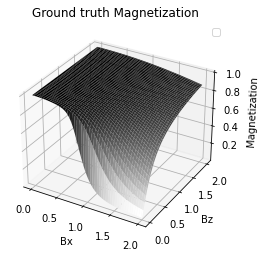

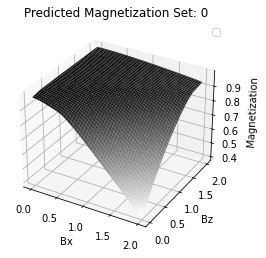

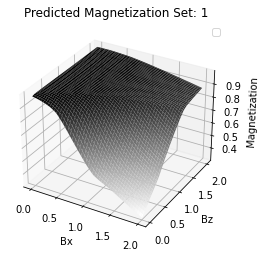

In [16]:
data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

x = np.reshape(Bx, (100, 100))
y = np.reshape(Bz, (100, 100))
z = np.reshape(mag_6_t, (100, 100))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

for i in range (runs):
    z = np.reshape(magnetization_6[i], (100, 100))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, cmap="binary")

    ax.legend()
    name = "Predicted Magnetization Set: " + str(i)
    ax.set_title(name)
    ax.set_xlabel("Bx")
    ax.set_ylabel("Bz")
    ax.set_zlabel("Magnetization")

    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


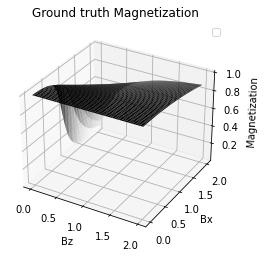

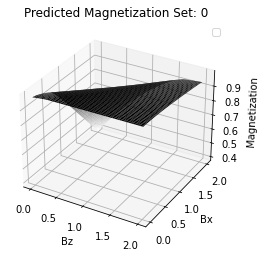

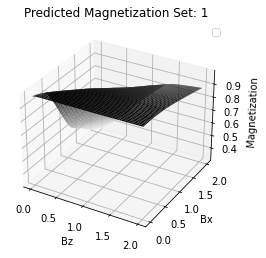

In [17]:
y = np.reshape(Bx, (100, 100))
x = np.reshape(Bz, (100, 100))
z = np.reshape(mag_6_t, (100, 100))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization")
ax.set_xlabel("Bz")
ax.set_ylabel("Bx")
ax.set_zlabel("Magnetization")

for i in range (runs):
    z = np.reshape(magnetization_6[i], (100, 100))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, cmap="binary")

    ax.legend()
    name = "Predicted Magnetization Set: " + str(i)
    ax.set_title(name)
    ax.set_xlabel("Bz")
    ax.set_ylabel("Bx")
    ax.set_zlabel("Magnetization")

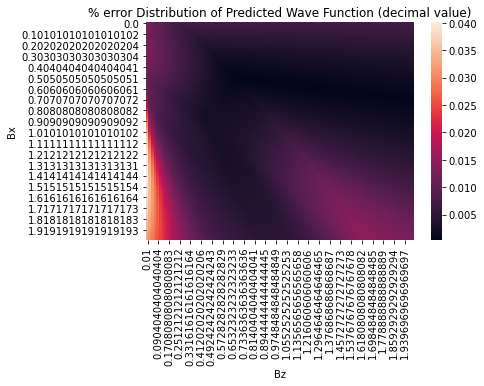

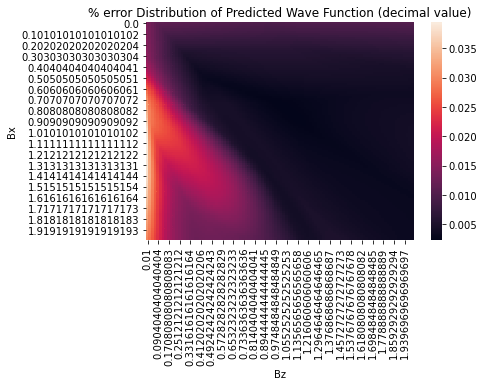

In [18]:
import pandas as pd
import seaborn as sns

data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

for i in error_p:
    data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error':i})
    data = data.pivot(index='Bx', columns='Bz', values='% error')
#    plt.hist2d(Bx, By, bins=N_bins, cmap='plasma')
    sns.heatmap(data)

    # Plot a colorbar with label.
#    cb = plt.colorbar()

    # Add title and labels to plot.
    plt.title('% error Distribution of Predicted Wave Function (decimal value)')
#     plt.xlabel('Bx')
#     plt.ylabel('Bz')

    # Show the plot.
    plt.show()